We consider an LTI system that represents a longitudinal aircraft dynamics. The matrix $A$ represents stability derivatives of a Boeing 747 aircraft cruising at an altitude of 40kft with speed 774 ft/sec.

Let $\dot{x} = Ax + B u$, with state $x = [u,\alpha,\dot{\theta}, \theta]^T \in \mathbb{R}^4$ comprised of deviations in aircraft speed, angle of attack, pitch-rate, and pitch angle respectively. The matrix $A$ is 
$$
A = \begin{pmatrix}
-0.0030 & 0.0390 & 0 & -0.3220 \\
-0.0650 & -0.3190 & 7.7400 & 0 \\
0.0200 & -0.1010 & -0.4290 & 0 \\
0 & 0 & 1 & 0
\end{pmatrix},
$$
and 
$$
B = \begin{pmatrix}
0.0100 \\ -0.1800 \\ -1.1600 \\ 0
\end{pmatrix}
$$
The input is $u \in [-13.3,13.3] \in \mathbb{R}$ (measured in degrees).


---
References:
1. A. Bryson. Control of Spacecraft and Aircraft. Princeton Univ. Press, 1994.
2. S. Kaynama, M. Oishi. Schur-Based decomposition for reachability analysis of Linear-Time-Invariant systems. Joint 48th IEEE Conf on Decision and Control, 2009.

In [1]:
import sys
sys.path.append('..')

from src.lgg import compute_flowpipe, plot_flowpipe
from lib.polyFunctions_core import BoxInfty

In [9]:
# set A and B in: dx/dt = Ax + Bu

# system coefficient matrix
A = matrix(QQ, 4, 4)
A.set_row(0, [-0.0030 , 0.0390 , 0 , -0.3220])
A.set_row(1, [-0.0650 , -0.3190 , 7.7400 , 0])
A.set_row(2, [0.0200 , -0.1010 , -0.4290 , 0])
A.set_row(3, [0 , 0 , 1 , 0])

B = matrix(QQ, 4, 1)
B.set_column(0,[0.01, -0.18, -1.16, 0])

# time horizon 
T = 0.5

# input range
U = BoxInfty(lengths=[[-13.3,13.3]])

# initial condition 
X0 = [1,1,1,0]
#X0 = BoxInfty(center = [1,1,1,0], radius = 0.001) # gives MIPSolverException

# time discretization 
tau = 1e-1

In [10]:
%%time
fp = compute_flowpipe(A, X0, B, U, time_horizon = T, time_step = tau, directions={'select':'box'}, base_ring = RDF)

CPU times: user 94.2 ms, sys: 47 ms, total: 141 ms
Wall time: 229 ms


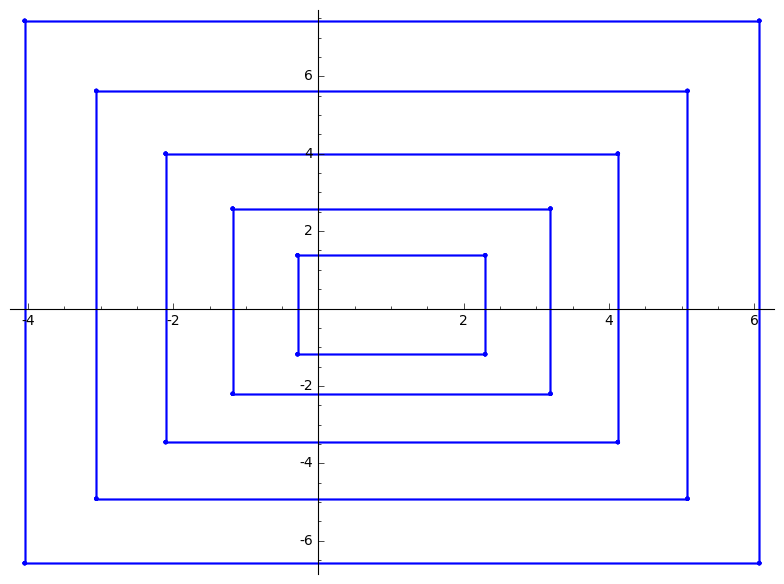

In [11]:
# plot the result
plot_flowpipe(fp, projection_directions = [0,3])

In [ ]:
p = fp[0]

In [ ]:
var('x')
p.projection(lambda x: [x[0],x[1]] )

In [ ]:
p = fp[0]

In [ ]:
p.projection?

In [ ]:
P = fp[0].projection()

In [ ]:
P.render_2d?

In [ ]:
fp[1].proj

In [ ]:
from sage.geometry.polyhedron.plot import Projection

In [ ]:
Projection(fp[0], proj = lambda x : [x[0], x[1]]).plot()